Heat transfer of railway brake disc

disc 2 can have heat conduction, which is better than disc 1.

This work, disc 3 use Neumann boundary conditon to input heat flux.

Author: yanjun zhang

# ds needs define correct

## 1: Start

Source from 
book "Abali - 2017 - Computational Reality" P119

In [1]:
import matplotlib.pyplot as plt
import pyvista
import ufl
import numpy as np
import dolfinx
from petsc4py import PETSc
from mpi4py import MPI
from dolfinx import fem, mesh, io, plot
from dolfinx.fem.petsc import assemble_vector, assemble_matrix, create_vector, apply_lifting, set_bc
import time

# Define temporal parameters
# Time  ----------------------------------------------------------------------
t0=time.time()
t = 0  # Start time
Total_time = 5  # Final time
num_steps = 50
dt = Total_time / num_steps  # time step size

# Boundary condtions --------------------------------------------------------- 
# initial temperature (K), and brake pad temperature
Ti, Tm = 250, 250

# This step is for the initial process. Variable need to be projected form Q onto V
def project(function, space):
    p = TrialFunction(space)
    q = TestFunction(space)
    a = inner(p, q) * dx
    L = inner(function, q) * dx
    problem = LinearProblem(a, L, bcs = [])
    return problem.solve()

# PhysicalProperties
# m to mm
unit_m_to_mm = 1e3
t_u = unit_m_to_mm

# density (kg.m^-3), capacity (J/Kg.K), conductivity (W/m.K)
rho , c ,k = 7850 /(t_u**3), 462 , 48 / t_u
mu , P_brake , v_angualr , r_disc , heat_distribution = 0.35, 246000, 48.3, 0.25, 0.88
h_input = mu * P_brake * v_angualr * r_disc * heat_distribution /1e9 *100

g = h_input

# f is the heat source,unit is w/m3

RhoCp_values = rho *c
Conductivity_values = k
Tinit_values = Ti

/home/yanjun/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## 2: Mesh

run mesh_brake disc.py to get disc.mesh

In [2]:
from dolfinx.io import gmshio
from dolfinx import plot
from dolfinx import default_scalar_type
from dolfinx.fem import (Constant, dirichletbc, Function, FunctionSpace, 
                         form,  locate_dofs_topological)
from dolfinx.fem.petsc import LinearProblem, assemble_matrix, create_vector, assemble_vector, apply_lifting, set_bc
from dolfinx.io import XDMFFile, gmshio
from dolfinx.mesh import create_unit_square, locate_entities, locate_entities_boundary,meshtags
from ufl import (SpatialCoordinate, TestFunction, TrialFunction,
                 dx, grad, inner, Measure, dot, jump, FacetNormal, avg, FiniteElement, MixedElement)
from find_com_e import find_common_e

filename = "3-10" # mesh
domain, cell_markers, facet_markers = gmshio.read_from_msh(filename+".msh", MPI.COMM_WORLD, 0, gdim=3)

Q = FunctionSpace(domain, ("DG", 0))
Conductivity = Function(Q)
Conductivity.x.array[:] = np.full_like(1, Conductivity_values, dtype=default_scalar_type)
RhoCp = Function(Q)
RhoCp.x.array[:] = np.full_like(1, RhoCp_values, dtype=default_scalar_type)

T_INIT = Function(Q)
T_INIT.name = "u_n"
# here 1 is the volume 1, the brake disc
T_INIT.x.array[:] = np.full_like(1, Tinit_values, dtype=default_scalar_type)


Info    : Reading '3-10.msh'...
Info    : 168 entities
Info    : 10751 nodes
Info    : 43604 elements
Info    : Done reading '3-10.msh'


In [3]:
# Create boundary condition
fdim = domain.topology.dim - 1
import sys
# when change a new computer, below path is inconvenient, need to find a bettwe way to use this function.
sys.path.append('/home/yanjun/Documents/FEniCSx/Tutorial/Mesh/')
from rub_co import get_rub_coordinate
x_co, y_co = get_rub_coordinate()

bc_list = []
for i, (x_c, y_c) in enumerate(zip(x_co, y_co), start=1):
    var_name = f"bc_facets{i}"    
    tag= mesh.locate_entities_boundary(
       domain, fdim, lambda x: (x[0]-x_c)**2 + (x[1]-y_c)**2  <= 324 )
    globals()[var_name] = tag
    bc_list.append(globals()[var_name])
    
# rubbing elements
bc_disc = mesh.locate_entities_boundary(
    domain, fdim , lambda x:  np.isclose(x[2], 20) )

bc_all = find_common_e(bc_disc, bc_list)


## 3: Initial condition

Note that we have used a much higher resolution that before to better resolve features of the solution.
We also easily update the intial and boundary conditions. Instead of using a class to define the initial condition, we simply use a function

In [4]:
# Create initial condition
from find_com_e import find_common_e

# Define variational problem, Here Lagrange changes to CG, what is CG?
V = fem.FunctionSpace(domain, ('CG', 1))

# initialization
# u_n is for initial condition and uh is the solver result.
u_n = fem.Function(V)
u_n.name = "u_n"
# variable, need to be projected form Q onto V
u_n = project(T_INIT,V)
u_n.name = "u_n"


## PETSC.Scalarype(X), this X is the value of boundary condition, like inlet temperature is 20, then here X is 20.
# Scalartype means constant value.
bc = fem.dirichletbc(PETSc.ScalarType(Tm), fem.locate_dofs_topological(V, fdim, bc_all), V)

print('1:fdim is','\n', fdim)
#print('2: boundary_facets is', '\n', bc_all)
#print('bc_all is','\n', bc_all)
print(bc_facets15)

1:fdim is 
 2
[42583 42584 42586 42591 42596 42597 42600 42605 42829 42945 43115 43117
 43121 43146 43148 43153 43334 43338 43341 43345 43567 43597 43858 43859
 43860 43885 43886 43887 75117 75124 75134 75136 75164 75173 75442 75753
 75815 75824 75853 75869 76126 76248 76476 76894 76896 76971 76972 77039
 77695 77839 77840 78171 78403 78406 78531 78532]


## 4: Time-dependent output


In [5]:
xdmf = io.XDMFFile(domain.comm, "temperature3.xdmf", "w")
xdmf.write_mesh(domain)

# Define solution variable, and interpolate initial solution for visualization in Paraview

#uh.interpolate(initial_condition)
#uh.interpolate(Tinit)
x = SpatialCoordinate(domain)

boundaries = [(1, lambda x: (x[0]-x_c)**2 + (x[1]-y_c)**2  <= 324)]

facet_indices, facet_markers = [], []
fdim = 2
for (marker, locator) in boundaries:
    facets = locate_entities(domain, fdim, locator)
    facet_indices.append(facets)
    facet_markers.append(np.full_like(facets, marker))
facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)
facet_tag = meshtags(domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])


g = h_input
#print(facet_indices)
ds = Measure('ds', domain=domain, subdomain_data=facet_tag)
ds1 = Measure('ds', domain=domain)
print(boundaries)
print(facet_tag)
print(ds)
print(ds1)


uh = fem.Function(V)
uh.name = "uh"
uh = project(T_INIT,V)
xdmf.write_function(uh, t)

[(1, <function <lambda> at 0x7155af72e950>)]
ds(subdomain_id=everywhere, domain=<Mesh #0>, subdomain_data=<dolfinx.mesh.MeshTags object at 0x7155bcaafca0>)
ds(subdomain_id=everywhere, domain=<Mesh #0>)


In [6]:
n = FacetNormal(domain)
print(ds)

ds(subdomain_id=everywhere, domain=<Mesh #0>, subdomain_data=<dolfinx.mesh.MeshTags object at 0x7155bcaafca0>)


## 5: Variational problem and solver


In [7]:
u, v = ufl.TrialFunction(V), ufl.TestFunction(V)
f = fem.Constant(domain, PETSc.ScalarType(0))
n = FacetNormal(domain)

a = (rho*c)/dt * u * v *dx + k* dot(grad(u), grad(v)) *dx -  k * dot(grad(u)*v, n)*ds(1)
# g is the heat flux, applied to the whole surface of the mesh
L = f *v *dx + (rho*c)/dt * u_n * v * dx   +  g* v *ds(1)



## 6: Preparing linear algebra structures for time dependent problems


In [8]:
# assembly matrix and vector
bilinear_form = fem.form(a)
linear_form = fem.form(L)

In [9]:
A = assemble_matrix(bilinear_form, bcs=[bc])
A.assemble()
b = create_vector(linear_form)

In [10]:
#print(b.view())
#print(A.view())

## 7: Using petsc4py to create a linear solver


In [11]:
solver = PETSc.KSP().create(domain.comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)

## 8:Visualization of time dependent problem using pyvista


In [12]:
import matplotlib as mpl
pyvista.start_xvfb()

grid = pyvista.UnstructuredGrid(*plot.vtk_mesh(V))

plotter = pyvista.Plotter()
plotter.open_gif("u_time3.gif", fps=30)

grid.point_data["uh"] = uh.x.array
warped = grid.warp_by_scalar("uh", factor=0)

viridis = mpl.colormaps.get_cmap("viridis").resampled(25)
sargs = dict(title_font_size=25, label_font_size=20, fmt="%.2e", color="black",
             position_x=0.1, position_y=0.8, width=0.8, height=0.1)

renderer = plotter.add_mesh(warped, show_edges=True, lighting=False,
                            cmap=viridis, scalar_bar_args=sargs,
                            #clim=[0, max(uh.x.array)])
                            clim=[Ti,  1.5*Tm])

## 9:Updating the solution and right hand side per time step


for i in range(num_steps):
    t += dt

    # Update the right hand side reusing the initial vector
    with b.localForm() as loc_b:
        loc_b.set(0)
    assemble_vector(b, linear_form)

    # Apply Dirichlet boundary condition to the vector
    apply_lifting(b, [bilinear_form], [[bc]])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b, [bc])

    # Solve linear problem
    solver.solve(b, uh.vector)
    uh.x.scatter_forward()

    # Update solution at previous time step (u_n)
    u_n.x.array[:] = uh.x.array

    # Write solution to file
    xdmf.write_function(uh, t)
    # Update plot
    warped = grid.warp_by_scalar("uh", factor=0)
    plotter.update_coordinates(warped.points.copy(), render=False)
    plotter.update_scalars(uh.x.array, render=False)
    plotter.write_frame()
plotter.close()
xdmf.close()

In [13]:
from rotation_co import rub_rotation
import numpy as np

degree = 10
total_degree = 0

for i in range(num_steps):
    t += dt
    # update the location
    x_co, y_co = rub_rotation (x_co, y_co, degree)
    bc_list = []    
    for i, (x_c, y_c) in enumerate(zip(x_co, y_co), start=1):
       var_name = f"bc_facets{i}"
       tag= mesh.locate_entities_boundary(
       domain, fdim, lambda x: (x[0]-x_c)**2 + (x[1]-y_c)**2  <= 324 )
       globals()[var_name] = tag
       bc_list.append(globals()[var_name])
    bc_disc = mesh.locate_entities_boundary(
        domain, fdim , lambda x:  np.isclose(x[2], 20) )
    bc_all = find_common_e(bc_disc, bc_list)
    bc = fem.dirichletbc(PETSc.ScalarType(Tm), fem.locate_dofs_topological(V, fdim, bc_all), V)
    
    total_degree += degree  # Incrementing degree by 10 in each step
    sys.stdout.write('\r1: Rotation has applied for {} degree. '.format(total_degree))
    sys.stdout.write('2: Current time is ' + str(round(t,1)) + " s. ")
    sys.stdout.write('3: Completion is '  + str(round (100*(t/Total_time),1) )+ " %. ")
    sys.stdout.flush()

    ## Matrix assemble
    A = assemble_matrix(bilinear_form, bcs=[bc])
    A.assemble()

    solver = PETSc.KSP().create(domain.comm)
    solver.setOperators(A)
    solver.setType(PETSc.KSP.Type.PREONLY)
    solver.getPC().setType(PETSc.PC.Type.LU)
              
    
    # Update the right hand side reusing the initial vector
    with b.localForm() as loc_b:
        loc_b.set(0)
    assemble_vector(b, linear_form)

    # Apply Dirichlet boundary condition to the vector
    apply_lifting(b, [bilinear_form], [[bc]])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b, [bc])

    
    # Solve linear problem
    solver.solve(b, uh.vector)
    uh.x.scatter_forward()

    # Update solution at previous time step (u_n)
    u_n.x.array[:] = uh.x.array
    # Write solution to file
    xdmf.write_function(uh, t)
    # Update plot
    #warped = grid.warp_by_scalar("uh", factor=0)
    plotter.update_coordinates(warped.points.copy(), render=False)
    plotter.update_scalars(uh.x.array, render=False)
    plotter.write_frame()
    
plotter.close() 
xdmf.close()
print()

1: Rotation has applied for 10 degree. 2: Current time is 0.1 s. 3: Completion is 2.0 %. 

  warnings.warn(

  warnings.warn(



1: Rotation has applied for 500 degree. 2: Current time is 5.0 s. 3: Completion is 100.0 %. 


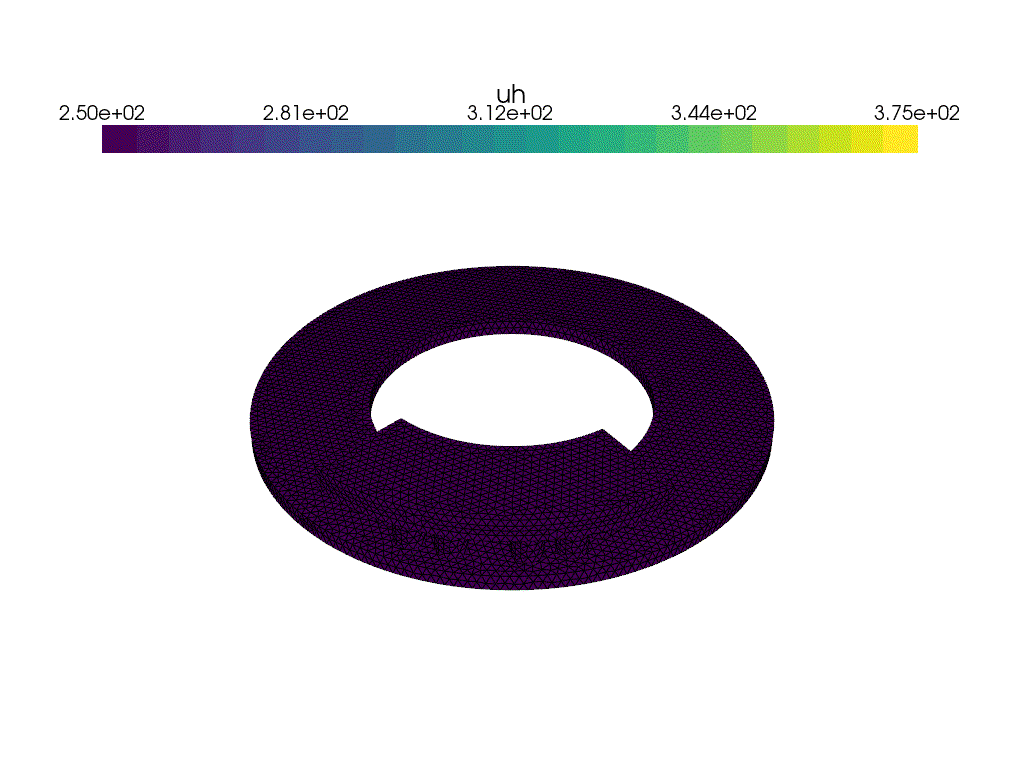

In [14]:
# Display the GIF
from IPython.display import display, Image

display(Image(filename = 'u_time3.gif'))